In [1]:
###########################################
# IMPORTS
###########################################
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools.constants import kB
from openmmtools.integrators import LangevinIntegrator

from simtk import unit, openmm

from perses.dispersed.utils import configure_platform
from perses.annihilation.lambda_protocol import RESTState, RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol
import numpy as np
import itertools
import copy

import pickle
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import mdtraj as md

#############################################
# CONSTANTS
#############################################
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
REFERENCE_PLATFORM = openmm.Platform.getPlatformByName("CUDA")

conducting subsequent work with the following platform: CUDA


DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.3
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections'

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


# Run vanilla MD on ala dipeptide at lambda = 0

In [37]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [38]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
1.0
0.0


In [39]:
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [40]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [41]:
energies, positions_old, positions_new = [], [], []

for _ in tqdm_notebook(range(250000)):
    integrator.step(1) 
    
#     # Get energy and positions
#     state = context.getState(getEnergy=True, getPositions=True)
#     energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
#     pos = state.getPositions(asNumpy=True)
#     old_pos = np.asarray(htf.old_positions(pos))
#     new_pos = np.asarray(htf.new_positions(pos))
#     positions_old.append(old_pos)
#     positions_new.append(new_pos)
    

/scratch/lsftmp/4064972.tmpdir/ipykernel_20372/2087871422.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(250000)):


  0%|          | 0/250000 [00:00<?, ?it/s]

In [ ]:
with open("ala_lambda_0_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_0_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_0_new.npy", "wb") as f:
    np.save(f, positions_new)
    

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

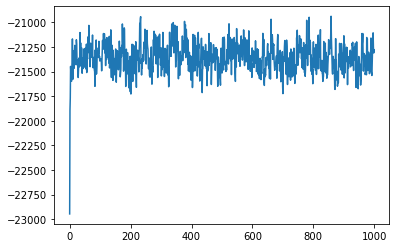

In [20]:
plt.plot(energies)
plt.show()


# Run vanilla MD on ala dipeptide at lambda = 0.5

In [8]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [9]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0.5
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


0.7071067811865476
0.5
0.5


In [10]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [11]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [ ]:
energies, positions_old, positions_new = [], [], []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get energy and positions
    state = context.getState(getEnergy=True, getPositions=True)
    energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    pos = state.getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    positions_old.append(old_pos)
    positions_new.append(new_pos)
    

/scratch/lsftmp/4043752.tmpdir/ipykernel_61267/1679595699.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
with open("ala_lambda_0.5_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_0.5_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_0.5_new.npy", "wb") as f:
    np.save(f, positions_new)
    

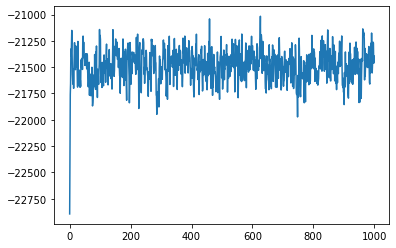

In [27]:
plt.plot(energies)
plt.show()


# Run vanilla MD on ala dipeptide at lambda = 1.0

In [151]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [45]:
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom)

0 ACE1-H1
1 ACE1-CH3
2 ACE1-H2
3 ACE1-H3
4 ACE1-C
5 ACE1-O
6 ALA2-N
7 ALA2-H
8 ALA2-CA
9 ALA2-HA
10 ALA2-CB
11 ALA2-HB1
12 ALA2-HB2
13 ALA2-HB3
14 ALA2-C
15 ALA2-O
1548 ALA2-HB
1549 ALA2-CG2
1550 ALA2-HG21
1551 ALA2-HG22
1552 ALA2-HG23
1553 ALA2-OG1
1554 ALA2-HG1
16 NME3-N
17 NME3-H
18 NME3-C
19 NME3-H1
20 NME3-H2
21 NME3-H3
22 HOH4-O
23 HOH4-H1
24 HOH4-H2
25 HOH5-O
26 HOH5-H1
27 HOH5-H2
28 HOH6-O
29 HOH6-H1
30 HOH6-H2
31 HOH7-O
32 HOH7-H1
33 HOH7-H2
34 HOH8-O
35 HOH8-H1
36 HOH8-H2
37 HOH9-O
38 HOH9-H1
39 HOH9-H2
40 HOH10-O
41 HOH10-H1
42 HOH10-H2
43 HOH11-O
44 HOH11-H1
45 HOH11-H2
46 HOH12-O
47 HOH12-H1
48 HOH12-H2
49 HOH13-O
50 HOH13-H1
51 HOH13-H2
52 HOH14-O
53 HOH14-H1
54 HOH14-H2
55 HOH15-O
56 HOH15-H1
57 HOH15-H2
58 HOH16-O
59 HOH16-H1
60 HOH16-H2
61 HOH17-O
62 HOH17-H1
63 HOH17-H2
64 HOH18-O
65 HOH18-H1
66 HOH18-H2
67 HOH19-O
68 HOH19-H1
69 HOH19-H2
70 HOH20-O
71 HOH20-H1
72 HOH20-H2
73 HOH21-O
74 HOH21-H1
75 HOH21-H2
76 HOH22-O
77 HOH22-H1
78 HOH22-H2
79 HOH23-O
80 HOH23-H1
81 

In [3]:
sterics_force = hybrid_system.getForce(5)
for i in range(sterics_force.getNumParticles()):
    print(i, sterics_force.getParticleParameters(i))
 

0 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2649532787749369, 0.2649532787749369, 0.06568879999999999, 0.06568879999999999)
1 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3399669508423535, 0.3399669508423535, 0.4577296, 0.4577296)
2 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2649532787749369, 0.2649532787749369, 0.06568879999999999, 0.06568879999999999)
3 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2649532787749369, 0.2649532787749369, 0.06568879999999999, 0.06568879999999999)
4 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3399669508423535, 0.3399669508423535, 0.359824, 0.359824)
5 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2959921901149463, 0.2959921901149463, 0.87864, 0.87864)
6 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3249998523775958, 0.3249998523775958, 0.7112800000000001, 0.7112800000000001)
7 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.10690784617684071, 0.10690784617684071, 0.06568879999999999, 0.06568879999999999)
8 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3399669508423535, 0.3399669508423535, 0.4577296, 0.4577296)
9 (1.0

1220 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1221 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1222 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3150752406575124, 0.3150752406575124, 0.635968, 0.635968)
1223 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1224 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1225 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3150752406575124, 0.3150752406575124, 0.635968, 0.635968)
1226 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1227 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1228 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3150752406575124, 0.3150752406575124, 0.635968, 0.635968)
1229 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1230 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1231 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3150752406575124, 0.3150752406575124, 0.635968, 0.635968)
1232 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1233 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1

In [5]:
sterics_force_og = htf._topology_proposal.new_system.getForce(3)
for i in range(sterics_force_og.getNumParticles()):
    print(i, sterics_force_og.getParticleParameters(i))
 

0 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
1 [Quantity(value=-0.3662, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.4577296, unit=kilojoule/mole)]
2 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
3 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
4 [Quantity(value=0.5972, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.359824, unit=kilojoule/mole)]
5 [Quantity(value=-0.5679, unit=elementary charge), Quantity(value=0.2959921901149463, unit=nanometer), Quantity(value=0.87864, unit=kilojoule/mole)]
6 [Quantity(value=-0.4157, unit=elementary charge), Quantity(valu

1360 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1361 [Quantity(value=-0.834, unit=elementary charge), Quantity(value=0.3150752406575124, unit=nanometer), Quantity(value=0.635968, unit=kilojoule/mole)]
1362 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1363 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1364 [Quantity(value=-0.834, unit=elementary charge), Quantity(value=0.3150752406575124, unit=nanometer), Quantity(value=0.635968, unit=kilojoule/mole)]
1365 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1366 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1367 [Quantity(value=-0.834, unit=

In [55]:
electrostatics_force = hybrid_system.getForce(4)
for i in range(electrostatics_force.getNumParticles()):
    print(i, electrostatics_force.getParticleParameters(i))
 

0 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1123, 0.1123)
1 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.3662, -0.3662)
2 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1123, 0.1123)
3 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1123, 0.1123)
4 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5972, 0.5972)
5 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.5679, -0.5679)
6 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.4157, -0.4157)
7 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2719, 0.2719)
8 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0337, -0.0389)
9 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0823, 0.1007)
10 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.1825, 0.3654)
11 (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0603, 0.0)
12 (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0603, 0.0)
13 (1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0603, 0.0)
14 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5973, 0.5973)
15 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.5679, -0.5679)
16 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.4157, -0.4157)
17 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2719, 0.2719)
18 (0.0, 1.0, 0.0

1490 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1491 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1492 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.834, -0.834)
1493 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1494 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1495 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.834, -0.834)
1496 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1497 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1498 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.834, -0.834)
1499 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1500 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1501 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.834, -0.834)
1502 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1503 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1504 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.834, -0.834)
1505 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1506 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.417, 0.417)
1507 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.834, -0.834

In [11]:
nb_force = hybrid_system.getForce(7)
for i in range(nb_force.getNumParticles()):
    charge, sigma, epsilon = nb_force.getParticleParameters(i)
    print(charge)
#     nb_force.setParticleParameters(i, charge*0, sigma, epsilon*0)
#     if sigma.value_in_unit_system(unit.md_unit_system) == 1.0:
#         print(i, sigma.value_in_unit_system(unit.md_unit_system))
 

0.1123 e
-0.3662 e
0.1123 e
0.1123 e
0.5972 e
-0.5679 e
-0.4157 e
0.2719 e
0.0337 e
0.0823 e
-0.1825 e
0.0603 e
0.0603 e
0.0603 e
0.5973 e
-0.5679 e
-0.4157 e
0.2719 e
-0.149 e
0.0976 e
0.0976 e
0.0976 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.417 e
-0.834 e
0.417 e
0.41

In [22]:
charge1, sigma, epsilon = nb_force.getParticleParameters(0)

In [23]:
charge2, sigma, epsilon = nb_force.getParticleParameters(2)

In [24]:
charge2 == charge1

True

In [41]:
nb_force = hybrid_system.getForce(7)
for i in range(nb_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
    nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)
#     if sigma.value_in_unit_system(unit.md_unit_system) == 0:
#     print(i, sigma.value_in_unit_system(unit.md_unit_system))
 

In [38]:
htf._atom_classes['unique_new_atoms']


{1548, 1549, 1550, 1551, 1552, 1553, 1554}

In [48]:
htf._atom_classes['unique_old_atoms']


{11, 12, 13}

In [49]:
htf._atom_classes['core_atoms']


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21}

In [132]:
electrostatics_force = hybrid_system.getForce(4)
sterics_force = hybrid_system.getForce(5)
exceptions_force = hybrid_system.getForce(6)
reciprocal_force = hybrid_system.getForce(7)

particles = [10, 1548, 1549, 1550, 1551, 1552, 1553, 1554]

# for i in particles:
#     params = sterics_force.getParticleParameters(i)
#     params = list(params)
#     params[-1] = params[-1]*0
#     params[-2] = params[-2]*0
#     sterics_force.setParticleParameters(i, params)

#     params = electrostatics_force.getParticleParameters(i)
#     params = list(params)
#     params[-1] = params[-1]*0
#     params[-2] = params[-2]*0
#     electrostatics_force.setParticleParameters(i, params)
    
#     charge, sigma, epsilon = reciprocal_force.getParticleParameters(i)
#     reciprocal_force.setParticleParameters(i, charge*0, sigma, epsilon*0)    

for i in range(exceptions_force.getNumBonds()):
    p1, p2, params = exceptions_force.getBondParameters(i)
    if p1 in particles or p2 in particles:
        params = list(params)
        params[-5] = params[-5]*0
        params[-6] = params[-6]*0
        params[-7] = params[-7]*0
        params[-8] = params[-8]*0
        params[-1] = params[-1]*0
        params[-2] = params[-2]*0
        exceptions_force.setBondParameters(i, p1, p2, params)

exception_indices = []
for i in range(reciprocal_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = reciprocal_force.getExceptionParameters(i)
    if p1 in particles or p2 in particles:
        exception_indices.append(i)
        reciprocal_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)

# for i in range(reciprocal_force.getNumParticleParameterOffsets()):
#     parameter, index, chargeScale, sigmaScale, epsilonScale = reciprocal_force.getParticleParameterOffset(i)
#     reciprocal_force.setParticleParameterOffset(i, parameter, index, chargeScale*0, sigmaScale*0, epsilonScale*0)

for i in range(reciprocal_force.getNumExceptionParameterOffsets()):
    parameter, index, chargeProdScale, sigmaScale, epsilonScale = reciprocal_force.getExceptionParameterOffset(i)
    if index in exception_indices:
        reciprocal_force.setExceptionParameterOffset(i, parameter, index, chargeProdScale*0, sigmaScale*0, epsilonScale*0)
    


In [152]:
hybrid_system.setParticleMass(10, 9 * unit.amu)

In [153]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

# print(compound_thermodynamic_state.lambda_rest_bonds)
# print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
# print(compound_thermodynamic_state.lambda_alchemical_bonds_new)
# print(compound_thermodynamic_state.lambda_alchemical_electrostatics_reciprocal)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_old)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_old)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_new)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_new)

In [154]:
# compound_thermodynamic_state.lambda_alchemical_electrostatics_reciprocal = 0
# compound_thermodynamic_state.lambda_alchemical_electrostatics_new = 0
# compound_thermodynamic_state.lambda_alchemical_electrostatics_exceptions_new = 0
# compound_thermodynamic_state.lambda_alchemical_sterics_new = 0
# compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_new = 0


In [155]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [156]:
for k, v in context.getParameters().items():
    print(k, v)

MonteCarloPressure 1.01325
MonteCarloTemperature 300.0
lambda_alchemical_angles_new 1.0
lambda_alchemical_angles_old 0.0
lambda_alchemical_bonds_new 1.0
lambda_alchemical_bonds_old 0.0
lambda_alchemical_electrostatics_exceptions_new 1.0
lambda_alchemical_electrostatics_exceptions_old 0.0
lambda_alchemical_electrostatics_new 1.0
lambda_alchemical_electrostatics_old 0.0
lambda_alchemical_electrostatics_reciprocal 1.0
lambda_alchemical_sterics_exceptions_new 1.0
lambda_alchemical_sterics_exceptions_old 0.0
lambda_alchemical_sterics_new 1.0
lambda_alchemical_sterics_old 0.0
lambda_alchemical_torsions_new 1.0
lambda_alchemical_torsions_old 0.0
lambda_rest_angles 1.0
lambda_rest_bonds 1.0
lambda_rest_electrostatics 1.0
lambda_rest_electrostatics_exceptions 1.0
lambda_rest_sterics 1.0
lambda_rest_sterics_exceptions 1.0
lambda_rest_torsions 1.0


In [157]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [158]:
energies, positions_old, positions_new = [], [], []

# for _ in tqdm_notebook(range(1000)):
#     integrator.step(250) 

for step in tqdm_notebook(range(250000)):
    integrator.step(1) 
    
#     if step > 10000:
    
#         # Get energy and positions
#         state = context.getState(getEnergy=True, getPositions=True)
#         energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
#         pos = state.getPositions(asNumpy=True)
#         old_pos = np.asarray(htf.old_positions(pos))
#         new_pos = np.asarray(htf.new_positions(pos))
#         positions_old.append(old_pos)
#         positions_new.append(new_pos)


/scratch/lsftmp/4076279.tmpdir/ipykernel_775686/3049236604.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(250000)):


  0%|          | 0/250000 [00:00<?, ?it/s]

In [168]:
hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b90d5f06c00> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b90d5f06ea0> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b90d5e6e540> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b90d5e6e6c0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b90d635f3f0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b90d635f780> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b90d5f960c0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b90d5f96300> >]

In [159]:
bond_force = hybrid_system.getForce(1)
for i in range(bond_force.getNumBonds()):
    print(bond_force.getBondParameters(i))

[4, 5, (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.12290000000000001, 0.12290000000000001, 476975.9999999999, 476975.9999999999)]
[4, 6, (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1335, 0.1335, 410031.99999999994, 410031.99999999994)]
[1, 4, (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1522, 0.1522, 265265.6, 265265.6)]
[14, 15, (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.12290000000000001, 0.12290000000000001, 476975.9999999999, 476975.9999999999)]
[14, 16, (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1335, 0.1335, 410031.99999999994, 410031.99999999994)]
[8, 10, (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1526, 0.1526, 259407.99999999994, 259407.99999999994)]
[8, 14, (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1522, 0.1522, 265265.6, 265265.6)]
[6, 8, (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1449, 0.1449, 282001.5999999999, 282001.5999999999)]
[16, 18, (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.1449, 0.1449, 282001.5999999999, 282001.5999999999)]
[10, 1549, (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.1526, 0.1526, 259407.99999999994, 25940

In [171]:
electrostatics_force = hybrid_system.getForce(4)
for i in range(electrostatics_force.getNumExclusions()):
    print(electrostatics_force.getExclusionParticles(i))

[1548, 11]
[1548, 12]
[1548, 13]
[1549, 11]
[1549, 12]
[1549, 13]
[1550, 11]
[1550, 12]
[1550, 13]
[1551, 11]
[1551, 12]
[1551, 13]
[1552, 11]
[1552, 12]
[1552, 13]
[1553, 11]
[1553, 12]
[1553, 13]
[1554, 11]
[1554, 12]
[1554, 13]
[0, 1]
[0, 2]
[1, 2]
[0, 3]
[1, 3]
[2, 3]
[0, 4]
[1, 4]
[2, 4]
[3, 4]
[0, 5]
[1, 5]
[2, 5]
[3, 5]
[4, 5]
[0, 6]
[1, 6]
[2, 6]
[3, 6]
[4, 6]
[5, 6]
[1, 7]
[4, 7]
[5, 7]
[6, 7]
[1, 8]
[4, 8]
[5, 8]
[6, 8]
[7, 8]
[4, 9]
[6, 9]
[7, 9]
[8, 9]
[4, 10]
[6, 10]
[7, 10]
[8, 10]
[9, 10]
[6, 11]
[8, 11]
[9, 11]
[10, 11]
[6, 12]
[8, 12]
[9, 12]
[10, 12]
[11, 12]
[6, 13]
[8, 13]
[9, 13]
[10, 13]
[11, 13]
[12, 13]
[4, 14]
[6, 14]
[7, 14]
[8, 14]
[9, 14]
[10, 14]
[11, 14]
[12, 14]
[13, 14]
[6, 15]
[8, 15]
[9, 15]
[10, 15]
[14, 15]
[6, 16]
[8, 16]
[9, 16]
[10, 16]
[14, 16]
[15, 16]
[8, 17]
[14, 17]
[15, 17]
[16, 17]
[8, 18]
[14, 18]
[15, 18]
[16, 18]
[17, 18]
[14, 19]
[16, 19]
[17, 19]
[18, 19]
[14, 20]
[16, 20]
[17, 20]
[18, 20]
[19, 20]
[14, 21]
[16, 21]
[17, 21]
[18, 21]


In [176]:
sterics_force = hybrid_system.getForce(5)
for i in range(sterics_force.getNumExclusions()):
    p1, p2 = sterics_force.getExclusionParticles(i)
    if sorted([p1, p2]) == [8,10]:
        print(i, p1, p2)

58 8 10


In [178]:
exceptions_force = hybrid_system.getForce(6)
for i in range(exceptions_force.getNumBonds()):
    p1, p2, params = exceptions_force.getBondParameters(i)
    if sorted([p1, p2]) == [8,10]:
        print(i, p1, p2, params)

37 8 10 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -0.00615025, -0.014214059999999999, 1.0, 1.0, 0.0, 0.0)


In [180]:
reciprocal_force = hybrid_system.getForce(7)
for i in range(reciprocal_force.getNumExceptions()):
    p1, p2, chargeProd, sigma, epsilon = reciprocal_force.getExceptionParameters(i)
    if sorted([p1, p2]) == [8,10]:
        print(i, p1, p2, chargeProd, sigma, epsilon)

58 8 10 0.0 e**2 1.0 nm 0.0 kJ/mol


In [161]:
bond_force = htf._topology_proposal.old_system.getForce(0)
for i in range(bond_force.getNumBonds()):
    print(bond_force.getBondParameters(i)) 

[4, 5, Quantity(value=0.12290000000000001, unit=nanometer), Quantity(value=476975.9999999999, unit=kilojoule/(nanometer**2*mole))]
[4, 6, Quantity(value=0.1335, unit=nanometer), Quantity(value=410031.99999999994, unit=kilojoule/(nanometer**2*mole))]
[1, 4, Quantity(value=0.1522, unit=nanometer), Quantity(value=265265.6, unit=kilojoule/(nanometer**2*mole))]
[14, 15, Quantity(value=0.12290000000000001, unit=nanometer), Quantity(value=476975.9999999999, unit=kilojoule/(nanometer**2*mole))]
[14, 16, Quantity(value=0.1335, unit=nanometer), Quantity(value=410031.99999999994, unit=kilojoule/(nanometer**2*mole))]
[8, 10, Quantity(value=0.1526, unit=nanometer), Quantity(value=259407.99999999994, unit=kilojoule/(nanometer**2*mole))]
[8, 14, Quantity(value=0.1522, unit=nanometer), Quantity(value=265265.6, unit=kilojoule/(nanometer**2*mole))]
[6, 8, Quantity(value=0.1449, unit=nanometer), Quantity(value=282001.5999999999, unit=kilojoule/(nanometer**2*mole))]
[16, 18, Quantity(value=0.1449, unit=na

In [141]:
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom, hybrid_system.getParticleMass(atom.index))

0 ACE1-H1 4.0 Da
1 ACE1-CH3 3.0340000000000007 Da
2 ACE1-H2 4.0 Da
3 ACE1-H3 4.0 Da
4 ACE1-C 12.01 Da
5 ACE1-O 16.0 Da
6 ALA2-N 11.018 Da
7 ALA2-H 4.0 Da
8 ALA2-CA 9.018 Da
9 ALA2-HA 4.0 Da
10 ALA2-CB 3.0340000000000007 Da
11 ALA2-HB1 4.0 Da
12 ALA2-HB2 4.0 Da
13 ALA2-HB3 4.0 Da
14 ALA2-C 12.01 Da
15 ALA2-O 16.0 Da
1548 ALA2-HB 4.0 Da
1549 ALA2-CG2 3.0340000000000007 Da
1550 ALA2-HG21 4.0 Da
1551 ALA2-HG22 4.0 Da
1552 ALA2-HG23 4.0 Da
1553 ALA2-OG1 13.008 Da
1554 ALA2-HG1 4.0 Da
16 NME3-N 11.018 Da
17 NME3-H 4.0 Da
18 NME3-C 3.0340000000000007 Da
19 NME3-H1 4.0 Da
20 NME3-H2 4.0 Da
21 NME3-H3 4.0 Da
22 HOH4-O 15.99943 Da
23 HOH4-H1 1.007947 Da
24 HOH4-H2 1.007947 Da
25 HOH5-O 15.99943 Da
26 HOH5-H1 1.007947 Da
27 HOH5-H2 1.007947 Da
28 HOH6-O 15.99943 Da
29 HOH6-H1 1.007947 Da
30 HOH6-H2 1.007947 Da
31 HOH7-O 15.99943 Da
32 HOH7-H1 1.007947 Da
33 HOH7-H2 1.007947 Da
34 HOH8-O 15.99943 Da
35 HOH8-H1 1.007947 Da
36 HOH8-H2 1.007947 Da
37 HOH9-O 15.99943 Da
38 HOH9-H1 1.007947 Da
39 HOH9-

981 HOH323-H2 1.007947 Da
982 HOH324-O 15.99943 Da
983 HOH324-H1 1.007947 Da
984 HOH324-H2 1.007947 Da
985 HOH325-O 15.99943 Da
986 HOH325-H1 1.007947 Da
987 HOH325-H2 1.007947 Da
988 HOH326-O 15.99943 Da
989 HOH326-H1 1.007947 Da
990 HOH326-H2 1.007947 Da
991 HOH327-O 15.99943 Da
992 HOH327-H1 1.007947 Da
993 HOH327-H2 1.007947 Da
994 HOH328-O 15.99943 Da
995 HOH328-H1 1.007947 Da
996 HOH328-H2 1.007947 Da
997 HOH329-O 15.99943 Da
998 HOH329-H1 1.007947 Da
999 HOH329-H2 1.007947 Da
1000 HOH330-O 15.99943 Da
1001 HOH330-H1 1.007947 Da
1002 HOH330-H2 1.007947 Da
1003 HOH331-O 15.99943 Da
1004 HOH331-H1 1.007947 Da
1005 HOH331-H2 1.007947 Da
1006 HOH332-O 15.99943 Da
1007 HOH332-H1 1.007947 Da
1008 HOH332-H2 1.007947 Da
1009 HOH333-O 15.99943 Da
1010 HOH333-H1 1.007947 Da
1011 HOH333-H2 1.007947 Da
1012 HOH334-O 15.99943 Da
1013 HOH334-H1 1.007947 Da
1014 HOH334-H2 1.007947 Da
1015 HOH335-O 15.99943 Da
1016 HOH335-H1 1.007947 Da
1017 HOH335-H2 1.007947 Da
1018 HOH336-O 15.99943 Da
1019 H

In [163]:
import openmmtools

In [164]:
atp = openmmtools.testsystems.AlanineDipeptideVacuum()

In [167]:
bond_force = atp.system.getForce(0)
for i in range(bond_force.getNumBonds()):
    print(bond_force.getBondParameters(i)) 

[4, 5, Quantity(value=0.12290000000000001, unit=nanometer), Quantity(value=476976.00000000006, unit=kilojoule/(nanometer**2*mole))]
[4, 6, Quantity(value=0.1335, unit=nanometer), Quantity(value=410032.00000000006, unit=kilojoule/(nanometer**2*mole))]
[1, 4, Quantity(value=0.1522, unit=nanometer), Quantity(value=265265.60000000003, unit=kilojoule/(nanometer**2*mole))]
[14, 15, Quantity(value=0.12290000000000001, unit=nanometer), Quantity(value=476976.00000000006, unit=kilojoule/(nanometer**2*mole))]
[14, 16, Quantity(value=0.1335, unit=nanometer), Quantity(value=410032.00000000006, unit=kilojoule/(nanometer**2*mole))]
[8, 10, Quantity(value=0.1526, unit=nanometer), Quantity(value=259408.00000000003, unit=kilojoule/(nanometer**2*mole))]
[8, 14, Quantity(value=0.1522, unit=nanometer), Quantity(value=265265.60000000003, unit=kilojoule/(nanometer**2*mole))]
[6, 8, Quantity(value=0.1449, unit=nanometer), Quantity(value=282001.60000000003, unit=kilojoule/(nanometer**2*mole))]
[16, 18, Quantit

In [61]:
htf._atom_classes['core_atoms']


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21}

In [48]:
with open("ala_lambda_1_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_1_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_1_new.npy", "wb") as f:
    np.save(f, positions_new)
    

In [24]:
with open("ala_lambda_1_energies.npy", "rb") as f:
    energies = np.load(f)

with open("ala_lambda_1_old.npy", "rb") as f:
    positions_old = np.load(f)

with open("ala_lambda_1_new.npy", "rb") as f:
    positions_new = np.load(f)
    

In [65]:
htf._atom_classes['unique_old_atoms']

{11, 12, 13}

In [66]:
htf._atom_classes['unique_new_atoms']

{1557, 1558, 1559, 1560, 1561, 1562, 1563}

In [71]:
htf._atom_classes['core_atoms']

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21}

In [73]:
htf._rest_region

[4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 16,
 17]

In [69]:
for i in {1557, 1558, 1559, 1560, 1561, 1562, 1563}:
    print(htf._hybrid_to_new_map[i])

13
14
15
16
17
18
19


In [27]:
for i, p in enumerate(positions_old[832]):
    print(i, p)

0 [1.13244556 0.55652141 2.28663996]
1 [1.07900205 0.55184162 2.38152352]
2 [1.14033025 0.53751803 2.47048804]
3 [1.00806764 0.47122096 2.36282544]
4 [0.99862295 0.67587739 2.37895184]
5 [1.06399186 0.77622366 2.42303299]
6 [0.87201025 0.6959791  2.35896365]
7 [0.81766082 0.61102317 2.36440683]
8 [0.79702673 0.81253633 2.35865006]
9 [0.81027485 0.86085295 2.26184618]
10 [1.30564917e+26 7.51942798e+25 1.26121162e+26]
11 [-9.22637897e+25 -5.17155748e+25 -1.01902633e+26]
12 [ 3.39410124e+24  2.24396021e+24 -1.03258254e+24]
13 [ 1.12894740e+24  5.70800545e+23 -8.12762078e+22]
14 [0.81609392 0.91399081 2.4773637 ]
15 [0.80949508 0.85503738 2.59131094]
16 [0.85082855 1.03839137 2.4278299 ]
17 [0.85786114 1.07979988 2.33597742]
18 [0.89158322 1.14102202 2.52581924]
19 [0.88482796 1.23914705 2.47884217]
20 [0.80987499 1.14876232 2.59754687]
21 [0.98688678 1.14034972 2.57871328]
22 [0.55492722 1.41952702 1.35984498]
23 [0.62076201 1.36345472 1.40088151]
24 [0.51920492 1.47133732 1.43196937]
25 

423 [0.55878392 2.17585323 0.12968659]
424 [0.73946254 0.01032132 0.52658724]
425 [0.79322403 0.08381294 0.49707449]
426 [ 0.76248118 -0.06146297  0.46760017]
427 [0.89244473 1.98759211 2.25876514]
428 [0.96767704 1.96387939 2.20454222]
429 [0.82184757 2.00365808 2.19615328]
430 [1.54702671 1.88341211 0.61967255]
431 [1.55286626 1.94982732 0.5509904 ]
432 [1.47113983 1.83037212 0.5953773 ]
433 [2.18256765 0.11417126 1.49627773]
434 [2.23254705 0.07377302 1.42533861]
435 [2.24169924 0.11206541 1.57151959]
436 [2.42932701 1.76947945 2.28033408]
437 [2.48696664 1.84589492 2.28115116]
438 [2.3432856  1.80406473 2.30406282]
439 [1.32749241 1.34154441 0.92828631]
440 [1.42219241 1.34425789 0.94195616]
441 [1.31485005 1.37783424 0.84061911]
442 [2.35254719 2.29678607 0.73205192]
443 [2.38491875 2.21918414 0.77779402]
444 [2.28460324 2.33195336 0.78957757]
445 [0.41600909 0.71030759 0.53509163]
446 [0.45574226 0.63233657 0.49630872]
447 [0.3343544  0.72227912 0.48659925]
448 [1.1808086 0.06994

821 [2.52628626 1.30553988 1.54140418]
822 [2.44051475 1.28395763 1.41853675]
823 [2.43365249 0.67038118 2.45380564]
824 [2.39376154 0.59417176 2.41181571]
825 [2.38109834 0.68466082 2.53252331]
826 [1.6510179  2.40003947 1.32398156]
827 [1.7055763  2.47780624 1.31223299]
828 [1.65378618 2.38277584 1.41809119]
829 [1.08229673 1.64619139 0.38986512]
830 [1.07488426 1.61178476 0.47887948]
831 [0.99327477 1.67289524 0.36696724]
832 [1.32763149 2.24597014 1.02058989]
833 [1.37323634 2.23579047 1.10412964]
834 [1.39745945 2.26041431 0.9567327 ]
835 [0.48291499 0.95656756 0.23323234]
836 [0.51894315 0.92878282 0.31744813]
837 [0.50838492 1.04850291 0.22539067]
838 [1.04076303 0.88539918 0.98229956]
839 [1.09087568 0.92396486 1.05415865]
840 [0.95553895 0.92877727 0.98648471]
841 [1.87512812 2.18254422 0.90853166]
842 [1.9616881  2.15119097 0.93473588]
843 [1.87721784 2.18160318 0.81283911]
844 [1.7853231  2.22317416 0.2818736 ]
845 [1.87648134 2.24663352 0.26449108]
846 [1.73438587 2.2814756

1209 [0.47170689 2.04217155 1.05407389]
1210 [2.48982272 0.62268058 1.46215313]
1211 [2.53683264 0.5445552  1.43301877]
1212 [2.55552828 0.69226581 1.46042315]
1213 [2.2434655  1.94099469 1.91076932]
1214 [2.1914622  1.94022667 1.99112717]
1215 [2.18287005 1.97154095 1.84326054]
1216 [2.01943506 2.37088066 0.18706711]
1217 [2.09630423 2.40729422 0.1431638 ]
1218 [1.94503857 2.40503471 0.13745883]
1219 [0.16639804 0.37083309 1.97602643]
1220 [0.21060281 0.43208068 2.03482261]
1221 [0.13284704 0.30218956 2.03368677]
1222 [2.47924943 0.11892718 0.91689679]
1223 [2.41492357 0.08615636 0.85404319]
1224 [2.50401117 0.20503335 0.88320846]
1225 [1.57235021 1.7708683  2.38175064]
1226 [1.54300441 1.74760845 2.29365909]
1227 [1.63328627 1.70112692 2.40594268]
1228 [1.03194551 2.13266013 0.7909011 ]
1229 [1.05118656 2.21564359 0.7472451 ]
1230 [0.94507843 2.10829507 0.75892028]
1231 [1.55635806 2.06567837 0.38152625]
1232 [1.64549679 2.08874149 0.35535952]
1233 [1.50514408 2.07260488 0.30095659]


In [29]:
for i, p in enumerate(positions_new[832]):
    print(i, p)

0 [1.13244556 0.55652141 2.28663996]
1 [1.07900205 0.55184162 2.38152352]
2 [1.14033025 0.53751803 2.47048804]
3 [1.00806764 0.47122096 2.36282544]
4 [0.99862295 0.67587739 2.37895184]
5 [1.06399186 0.77622366 2.42303299]
6 [0.87201025 0.6959791  2.35896365]
7 [0.81766082 0.61102317 2.36440683]
8 [0.79702673 0.81253633 2.35865006]
9 [0.81027485 0.86085295 2.26184618]
10 [1.30564917e+26 7.51942798e+25 1.26121162e+26]
11 [0.81609392 0.91399081 2.4773637 ]
12 [0.80949508 0.85503738 2.59131094]
13 [-1.12927482e+25 -8.13404716e+24  7.35358989e+24]
14 [0.53673474 0.88842214 2.37766388]
15 [0.53140873 0.95805274 2.2939727 ]
16 [0.43442031 0.85320882 2.39080847]
17 [0.56240491 0.95406674 2.4608073 ]
18 [0.60701936 0.69202515 2.25516227]
19 [0.66658881 0.70323787 2.18071929]
20 [0.85082855 1.03839137 2.4278299 ]
21 [0.85786114 1.07979988 2.33597742]
22 [0.89158322 1.14102202 2.52581924]
23 [0.88482796 1.23914705 2.47884217]
24 [0.80987499 1.14876232 2.59754687]
25 [0.98688678 1.14034972 2.57871

421 [0.92782396 0.63257655 0.28987714]
422 [0.09706791 1.98419343 1.8023994 ]
423 [0.12827421 1.97804777 1.71211809]
424 [0.03534278 2.05734785 1.80152837]
425 [0.52631162 2.08758261 0.11190553]
426 [0.53821378 2.04055773 0.19442413]
427 [0.55878392 2.17585323 0.12968659]
428 [0.73946254 0.01032132 0.52658724]
429 [0.79322403 0.08381294 0.49707449]
430 [ 0.76248118 -0.06146297  0.46760017]
431 [0.89244473 1.98759211 2.25876514]
432 [0.96767704 1.96387939 2.20454222]
433 [0.82184757 2.00365808 2.19615328]
434 [1.54702671 1.88341211 0.61967255]
435 [1.55286626 1.94982732 0.5509904 ]
436 [1.47113983 1.83037212 0.5953773 ]
437 [2.18256765 0.11417126 1.49627773]
438 [2.23254705 0.07377302 1.42533861]
439 [2.24169924 0.11206541 1.57151959]
440 [2.42932701 1.76947945 2.28033408]
441 [2.48696664 1.84589492 2.28115116]
442 [2.3432856  1.80406473 2.30406282]
443 [1.32749241 1.34154441 0.92828631]
444 [1.42219241 1.34425789 0.94195616]
445 [1.31485005 1.37783424 0.84061911]
446 [2.35254719 2.2967

800 [2.03548705 1.39863302 1.72039537]
801 [2.08945822 1.32542412 1.69056438]
802 [1.96609367 1.35776978 1.7721358 ]
803 [0.8524357 1.1238707 1.8009931]
804 [0.85461964 1.03663085 1.84032194]
805 [0.84389877 1.18351777 1.87536827]
806 [0.09224767 1.60001699 0.42697584]
807 [0.0610547  1.53337185 0.36575703]
808 [0.13182912 1.66708419 0.3713196 ]
809 [1.23149679 2.38105335 0.39167391]
810 [1.25905424 2.29401986 0.42045023]
811 [1.31259425 2.42426283 0.36486977]
812 [0.26585873 1.39728323 2.23217298]
813 [0.18769289 1.39415134 2.17701311]
814 [0.31861045 1.32281485 2.20329332]
815 [0.81105151 2.32480163 0.35432758]
816 [0.87470489 2.35779577 0.29090872]
817 [0.82978034 2.23114299 0.36062104]
818 [0.5595599  1.32539323 2.48353714]
819 [0.6310016  1.3877073  2.47029481]
820 [0.53523342 1.29764951 2.39521485]
821 [2.44229907 2.21321337 0.44742218]
822 [2.40094551 2.28127429 0.39431935]
823 [2.46180433 2.25625923 0.5306623 ]
824 [2.47121776 1.24036064 1.49802855]
825 [2.52628626 1.30553988 1

1209 [0.08240039 2.53009602 0.59256829]
1210 [0.0371041  2.41234611 0.67624718]
1211 [0.55762205 2.01601308 1.02095836]
1212 [0.61774434 2.03423669 1.09317698]
1213 [0.47170689 2.04217155 1.05407389]
1214 [2.48982272 0.62268058 1.46215313]
1215 [2.53683264 0.5445552  1.43301877]
1216 [2.55552828 0.69226581 1.46042315]
1217 [2.2434655  1.94099469 1.91076932]
1218 [2.1914622  1.94022667 1.99112717]
1219 [2.18287005 1.97154095 1.84326054]
1220 [2.01943506 2.37088066 0.18706711]
1221 [2.09630423 2.40729422 0.1431638 ]
1222 [1.94503857 2.40503471 0.13745883]
1223 [0.16639804 0.37083309 1.97602643]
1224 [0.21060281 0.43208068 2.03482261]
1225 [0.13284704 0.30218956 2.03368677]
1226 [2.47924943 0.11892718 0.91689679]
1227 [2.41492357 0.08615636 0.85404319]
1228 [2.50401117 0.20503335 0.88320846]
1229 [1.57235021 1.7708683  2.38175064]
1230 [1.54300441 1.74760845 2.29365909]
1231 [1.63328627 1.70112692 2.40594268]
1232 [1.03194551 2.13266013 0.7909011 ]
1233 [1.05118656 2.21564359 0.7472451 ]


In [81]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom.index, atom)

0 <Atom 0 (H1) of chain 0 residue 0 (ACE)>
1 <Atom 1 (CH3) of chain 0 residue 0 (ACE)>
2 <Atom 2 (H2) of chain 0 residue 0 (ACE)>
3 <Atom 3 (H3) of chain 0 residue 0 (ACE)>
4 <Atom 4 (C) of chain 0 residue 0 (ACE)>
5 <Atom 5 (O) of chain 0 residue 0 (ACE)>
6 <Atom 6 (N) of chain 0 residue 1 (THR)>
7 <Atom 7 (H) of chain 0 residue 1 (THR)>
8 <Atom 8 (CA) of chain 0 residue 1 (THR)>
9 <Atom 9 (HA) of chain 0 residue 1 (THR)>
10 <Atom 10 (CB) of chain 0 residue 1 (THR)>
11 <Atom 11 (C) of chain 0 residue 1 (THR)>
12 <Atom 12 (O) of chain 0 residue 1 (THR)>
13 <Atom 13 (HB) of chain 0 residue 1 (THR)>
14 <Atom 14 (CG2) of chain 0 residue 1 (THR)>
15 <Atom 15 (HG21) of chain 0 residue 1 (THR)>
16 <Atom 16 (HG22) of chain 0 residue 1 (THR)>
17 <Atom 17 (HG23) of chain 0 residue 1 (THR)>
18 <Atom 18 (OG1) of chain 0 residue 1 (THR)>
19 <Atom 19 (HG1) of chain 0 residue 1 (THR)>
20 <Atom 20 (N) of chain 0 residue 2 (NME)>
21 <Atom 21 (H) of chain 0 residue 2 (NME)>
22 <Atom 22 (C) of chain 0 r

In [57]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom.index, atom)

0 <Atom 0 (H1) of chain 0 residue 0 (ACE)>
1 <Atom 1 (CH3) of chain 0 residue 0 (ACE)>
2 <Atom 2 (H2) of chain 0 residue 0 (ACE)>
3 <Atom 3 (H3) of chain 0 residue 0 (ACE)>
4 <Atom 4 (C) of chain 0 residue 0 (ACE)>
5 <Atom 5 (O) of chain 0 residue 0 (ACE)>
6 <Atom 6 (N) of chain 0 residue 1 (ALA)>
7 <Atom 7 (H) of chain 0 residue 1 (ALA)>
8 <Atom 8 (CA) of chain 0 residue 1 (ALA)>
9 <Atom 9 (HA) of chain 0 residue 1 (ALA)>
10 <Atom 10 (CB) of chain 0 residue 1 (ALA)>
11 <Atom 11 (HB1) of chain 0 residue 1 (ALA)>
12 <Atom 12 (HB2) of chain 0 residue 1 (ALA)>
13 <Atom 13 (HB3) of chain 0 residue 1 (ALA)>
14 <Atom 14 (C) of chain 0 residue 1 (ALA)>
15 <Atom 15 (O) of chain 0 residue 1 (ALA)>
16 <Atom 16 (N) of chain 0 residue 2 (NME)>
17 <Atom 17 (H) of chain 0 residue 2 (NME)>
18 <Atom 18 (C) of chain 0 residue 2 (NME)>
19 <Atom 19 (H1) of chain 0 residue 2 (NME)>
20 <Atom 20 (H2) of chain 0 residue 2 (NME)>
21 <Atom 21 (H3) of chain 0 residue 2 (NME)>
22 <Atom 22 (O) of chain 1 residue 

1526 <Atom 1526 (H1) of chain 1 residue 504 (HOH)>
1527 <Atom 1527 (H2) of chain 1 residue 504 (HOH)>
1528 <Atom 1528 (O) of chain 1 residue 505 (HOH)>
1529 <Atom 1529 (H1) of chain 1 residue 505 (HOH)>
1530 <Atom 1530 (H2) of chain 1 residue 505 (HOH)>
1531 <Atom 1531 (O) of chain 1 residue 506 (HOH)>
1532 <Atom 1532 (H1) of chain 1 residue 506 (HOH)>
1533 <Atom 1533 (H2) of chain 1 residue 506 (HOH)>
1534 <Atom 1534 (O) of chain 1 residue 507 (HOH)>
1535 <Atom 1535 (H1) of chain 1 residue 507 (HOH)>
1536 <Atom 1536 (H2) of chain 1 residue 507 (HOH)>
1537 <Atom 1537 (O) of chain 1 residue 508 (HOH)>
1538 <Atom 1538 (H1) of chain 1 residue 508 (HOH)>
1539 <Atom 1539 (H2) of chain 1 residue 508 (HOH)>
1540 <Atom 1540 (O) of chain 1 residue 509 (HOH)>
1541 <Atom 1541 (H1) of chain 1 residue 509 (HOH)>
1542 <Atom 1542 (H2) of chain 1 residue 509 (HOH)>
1543 <Atom 1543 (O) of chain 1 residue 510 (HOH)>
1544 <Atom 1544 (H1) of chain 1 residue 510 (HOH)>
1545 <Atom 1545 (H2) of chain 1 resid

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

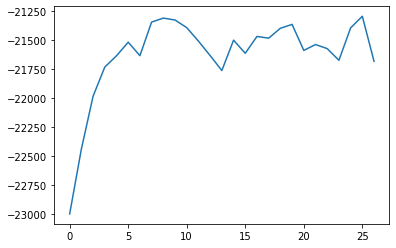

In [8]:
plt.plot(energies)
plt.show()


## Generate dcds

In [51]:
with open("ala_lambda_1_old.npy", 'rb') as f:
    old = np.load(f)

traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 887, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_1_old.dcd")
traj[0].save("ala_lambda_1_old.pdb")

In [52]:
with open("ala_lambda_1_new.npy", 'rb') as f:
    new = np.load(f)

traj = md.Trajectory(np.array(new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 887, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_1_new.dcd")
traj[0].save("ala_lambda_1_new.pdb")

In [ ]:
with open("ala_lambda_0.5_old.npy", 'rb') as f:
    old = np.load(f)

traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_0.5_old.dcd")
traj[0].save("ala_lambda_0.5_old.pdb")

In [ ]:
with open("ala_lambda_0.5_new.npy", 'rb') as f:
    new = np.load(f)

traj = md.Trajectory(np.array(new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_0.5_new.dcd")
traj[0].save("ala_lambda_0.5_new.pdb")